# Mid Circuit Measurement 2 classes Debug


In [1]:
import torch
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from data_utils import mnist_preparation 
from evaluationUtils import calculate_mcm_accuracy
from tqdm import tqdm
import matplotlib as plt
from OriginalModel import FullQuantumModel, QuantumCircuit
from mcmModel import MCMQuantumModel, MCMCircuit
from pennylane import Device
from pennylane.measurements import StateMP
from torch.nn import Module, ParameterDict
import matplotlib.pyplot as plt
import warnings
from typing import Optional, Dict, List, Any
from torch.utils.data import DataLoader, dataloader
from time import time
import math
from pennylane.measurements import MidMeasureMP
torch.manual_seed(1234)

First of all let's import data with train/validation/test split of 70/15/15. 

In [2]:
labels = [0,1]
# Download MNIST and prepare transforms
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([
                                transforms.Resize((16, 16)),  # Resize to 16x16
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))  # Normalize
                             ]))
#train/vali/test 70/15/15 split, see data_utils.py for further details
train_dataloader, validation_dataloader, test_dataloader = mnist_preparation(dataset=mnist, labels = labels, train_test_ratio=0.7,batch_size=64, vali_test_ratio=0.5)

print("Images in the training set: ", len(train_dataloader.dataset), "\n Images in the validation set: ", len(validation_dataloader.dataset), "\n Images in the test set: ", len(test_dataloader.dataset))

Images in the training set:  8865 
 Images in the validation set:  1900 
 Images in the test set:  1900


# Baseline Model

See [OriginalModel.py](https://github.com/JackVittori/QML-early_exit/blob/main/OriginalModel.py) for further details. Highlights are hereafter reported: 

- a layer is composed by RX, RY, RZ rotations on each qubit and CNOT gates to create entanglement (24 params x layer); 
- the quantum circuit return is the quantum state;
- probability is extracted from the first qubit using the following Python code (the first 128 states are associated to measuring 0 on the first qubit, the others to measuring 1):   
```python 
if self.num_classes == 2:
    state_vector = self.quantum_layer(state=state, num_layers_to_execute=num_layers_to_execute)
    probabilities = torch.sum(torch.abs(state_vector[:, :2 ** (self.quantum_layer.num_qubits - 1)]) ** 2, dim=1)
    return probabilities.type(torch.float32)
```
- train with ```python torch.nn.BCELoss()```

Trainable parameters: 192


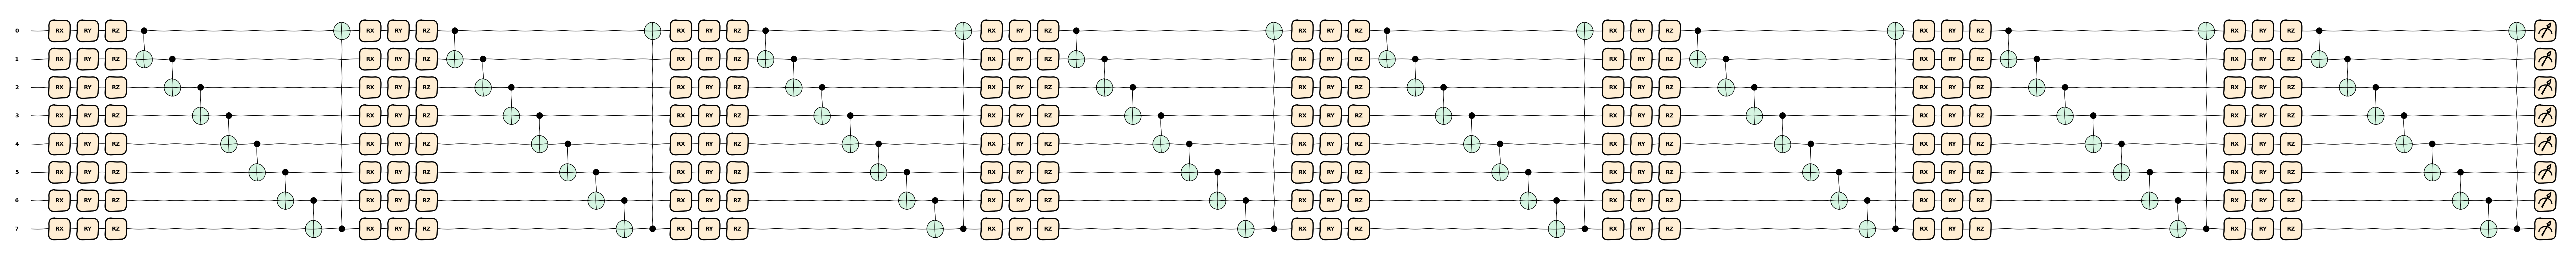

In [3]:
baseline = FullQuantumModel(qubits=8, layers=8, num_classes=2)
baseline.trainable_parameters()
baseline.draw(style='sketch')

In [4]:
#We could freeze a layer if we want with the following method of the class in OriginalModel.py
baseline.freeze_layers([0,1])
baseline.trainable_layers()
baseline.trainable_parameters()

{'layer_0': False, 'layer_1': False, 'layer_2': True, 'layer_3': True, 'layer_4': True, 'layer_5': True, 'layer_6': True, 'layer_7': True}
Trainable parameters: 144


In [5]:
# We can also unfreeze them
baseline.unfreeze_layers([0,1])
baseline.trainable_layers()
baseline.trainable_parameters()

{'layer_0': True, 'layer_1': True, 'layer_2': True, 'layer_3': True, 'layer_4': True, 'layer_5': True, 'layer_6': True, 'layer_7': True}
Trainable parameters: 192


Epoch 1/20: 100%|██████████| 138/138 [00:08<00:00, 16.81it/s, accuracy=1, loss=0.454]    


Time per epoch:  8.219119787216187
Epoch:  1 Loss:  0.5570120943197305
Accuracy:  0.8836050724637681
--------------------------------------------------------------------------


Epoch 2/20: 100%|██████████| 138/138 [00:07<00:00, 17.44it/s, accuracy=0.984, loss=0.361]


Time per epoch:  7.914952039718628
Epoch:  2 Loss:  0.41268546771312103
Accuracy:  0.9916213768115942
--------------------------------------------------------------------------


Epoch 3/20: 100%|██████████| 138/138 [00:07<00:00, 18.37it/s, accuracy=0.984, loss=0.339]


Time per epoch:  7.511418104171753
Epoch:  3 Loss:  0.3601142094619032
Accuracy:  0.995697463768116
--------------------------------------------------------------------------


Epoch 4/20: 100%|██████████| 138/138 [00:07<00:00, 18.39it/s, accuracy=1, loss=0.33]     


Time per epoch:  7.503380060195923
Epoch:  4 Loss:  0.3325627994710121
Accuracy:  0.9968297101449275
--------------------------------------------------------------------------


Epoch 5/20: 100%|██████████| 138/138 [00:07<00:00, 18.39it/s, accuracy=1, loss=0.316]    


Time per epoch:  7.504271984100342
Epoch:  5 Loss:  0.3210805313310761
Accuracy:  0.9969429347826086
--------------------------------------------------------------------------


Epoch 6/20: 100%|██████████| 138/138 [00:07<00:00, 18.35it/s, accuracy=0.984, loss=0.319]


Time per epoch:  7.5224690437316895
Epoch:  6 Loss:  0.3123081246579903
Accuracy:  0.9966032608695652
--------------------------------------------------------------------------


Epoch 7/20: 100%|██████████| 138/138 [00:07<00:00, 18.33it/s, accuracy=1, loss=0.298]    


Time per epoch:  7.527951002120972
Epoch:  7 Loss:  0.30395164653874823
Accuracy:  0.9962635869565217
--------------------------------------------------------------------------


Epoch 8/20: 100%|██████████| 138/138 [00:07<00:00, 18.29it/s, accuracy=0.984, loss=0.281]


Time per epoch:  7.546282052993774
Epoch:  8 Loss:  0.29695064045380853
Accuracy:  0.9961503623188406
--------------------------------------------------------------------------


Epoch 9/20: 100%|██████████| 138/138 [00:07<00:00, 18.25it/s, accuracy=1, loss=0.287]    


Time per epoch:  7.563946962356567
Epoch:  9 Loss:  0.29146568628324976
Accuracy:  0.9960371376811594
--------------------------------------------------------------------------


Epoch 10/20: 100%|██████████| 138/138 [00:07<00:00, 18.29it/s, accuracy=1, loss=0.272]    


Time per epoch:  7.545844078063965
Epoch:  10 Loss:  0.2868997389855592
Accuracy:  0.9961503623188406
--------------------------------------------------------------------------


Epoch 11/20: 100%|██████████| 138/138 [00:07<00:00, 18.19it/s, accuracy=1, loss=0.282]    


Time per epoch:  7.588595151901245
Epoch:  11 Loss:  0.2833143924025522
Accuracy:  0.9961503623188406
--------------------------------------------------------------------------


Epoch 12/20: 100%|██████████| 138/138 [00:07<00:00, 18.29it/s, accuracy=1, loss=0.272]    


Time per epoch:  7.545047044754028
Epoch:  12 Loss:  0.28038236369257385
Accuracy:  0.9961503623188406
--------------------------------------------------------------------------


Epoch 13/20: 100%|██████████| 138/138 [00:07<00:00, 18.33it/s, accuracy=1, loss=0.258]    


Time per epoch:  7.528941869735718
Epoch:  13 Loss:  0.27768905568813934
Accuracy:  0.9961503623188406
--------------------------------------------------------------------------


Epoch 14/20: 100%|██████████| 138/138 [00:07<00:00, 18.34it/s, accuracy=1, loss=0.261]    


Time per epoch:  7.526555776596069
Epoch:  14 Loss:  0.2753231621522834
Accuracy:  0.9960371376811594
--------------------------------------------------------------------------


Epoch 15/20: 100%|██████████| 138/138 [00:07<00:00, 18.35it/s, accuracy=1, loss=0.257]    


Time per epoch:  7.519682884216309
Epoch:  15 Loss:  0.27290413247934286
Accuracy:  0.9960371376811594
--------------------------------------------------------------------------


Epoch 16/20: 100%|██████████| 138/138 [00:07<00:00, 18.09it/s, accuracy=1, loss=0.274]    


Time per epoch:  7.630975008010864
Epoch:  16 Loss:  0.270384527310945
Accuracy:  0.996490036231884
--------------------------------------------------------------------------


Epoch 17/20: 100%|██████████| 138/138 [00:07<00:00, 18.05it/s, accuracy=0.984, loss=0.27] 


Time per epoch:  7.645708084106445
Epoch:  17 Loss:  0.2678703283486159
Accuracy:  0.9967164855072463
--------------------------------------------------------------------------


Epoch 18/20: 100%|██████████| 138/138 [00:07<00:00, 18.36it/s, accuracy=1, loss=0.267]    


Time per epoch:  7.519085168838501
Epoch:  18 Loss:  0.2655147208251815
Accuracy:  0.9968297101449275
--------------------------------------------------------------------------


Epoch 19/20: 100%|██████████| 138/138 [00:07<00:00, 18.27it/s, accuracy=1, loss=0.26]     


Time per epoch:  7.55248498916626
Epoch:  19 Loss:  0.26393125821714813
Accuracy:  0.9967164855072463
--------------------------------------------------------------------------


Epoch 20/20: 100%|██████████| 138/138 [00:07<00:00, 18.41it/s, accuracy=1, loss=0.25]     


Time per epoch:  7.49643087387085
Epoch:  20 Loss:  0.2629110510798468
Accuracy:  0.9966032608695652
--------------------------------------------------------------------------


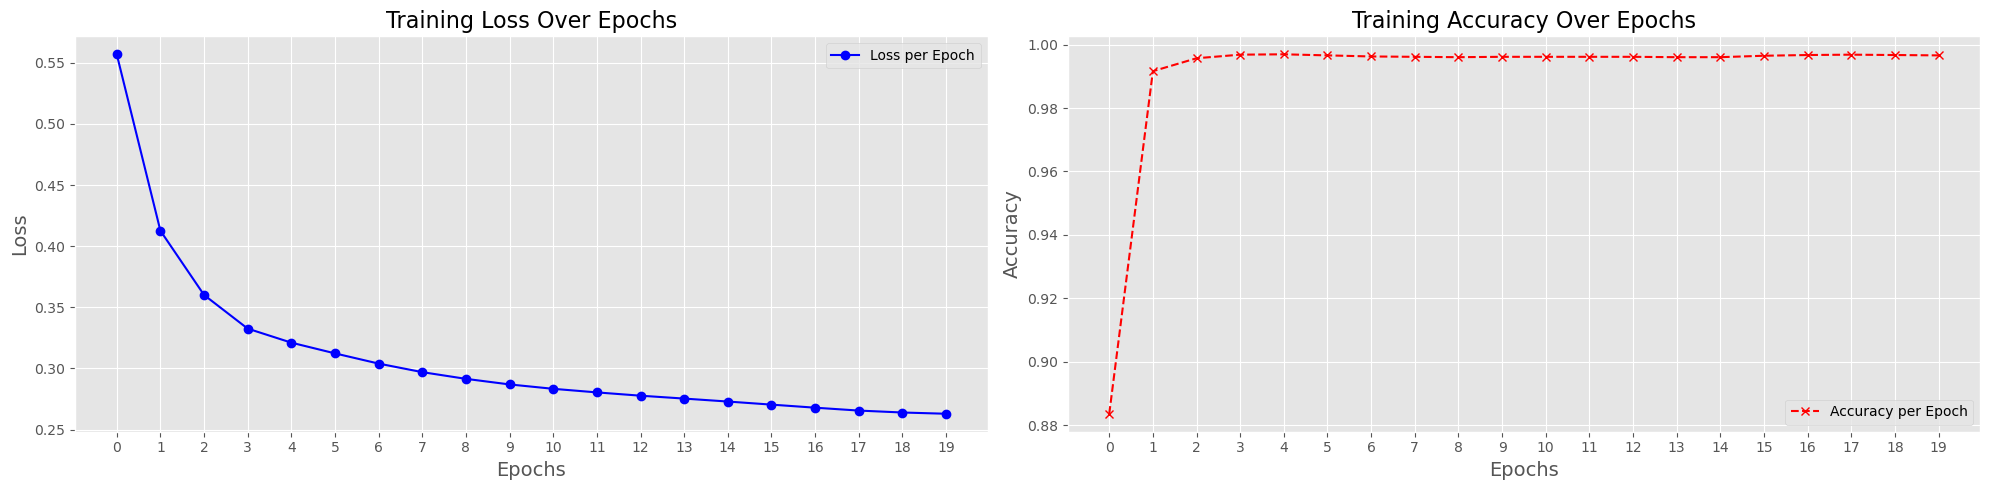

In [6]:
accuracy_history, loss_history = baseline.fit(dataloader=train_dataloader, learning_rate=0.001, epochs=20, show_plot=True)

## Baseline evaluation

In [7]:
baseline.freeze_layers([0,1,2,3,4,5,6,7])
baseline.trainable_parameters()

#simplified per image test set evaluation
result = []
for img, label in tqdm(test_dataloader.dataset):
    img = img / torch.linalg.norm(img).view(-1, 1) #image normalization
    pred = torch.round(baseline.forward(state=img)) #extract pred
    result.append((pred, label))
    
def calculate_accuracy(data):
    correct = sum([1 for label, prediction in data if label == prediction])
    return correct, correct / len(data)

test_results = calculate_accuracy(result)

print(test_results[0], "elements have been correctly classified over", len(test_dataloader.dataset), "total images with an accuracy of ", test_results[1])

Trainable parameters: 0


100%|██████████| 1900/1900 [00:30<00:00, 61.75it/s]

1889 elements have been correctly classified over 1900 total images with an accuracy of  0.9942105263157894


# MCM model



In [8]:
mcm_model = MCMQuantumModel(qubits=8, layers=8, ansatz='2-class')

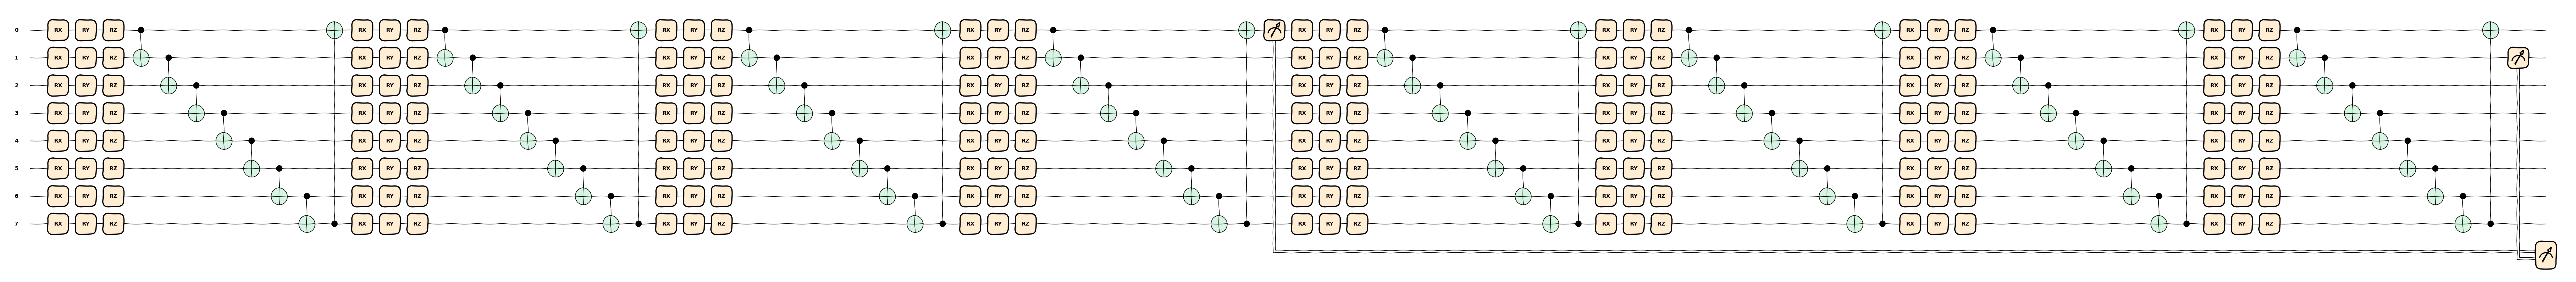

In [9]:
mcm_model.draw(style='sketch', path="mcm_model.png")

Epoch 1/20: 100%|██████████| 138/138 [00:21<00:00,  6.49it/s, fm_accuracy=1, loss=1.08, mcm_accuracy=0.984]    


Time per epoch (s):  21.271149158477783
Epoch:  1 Loss:  1.1953173677126567
--------------------------------------------------------------------------
Mid circuit accuracy:  0.8596014492753623
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9737318840579711
--------------------------------------------------------------------------


Epoch 2/20: 100%|██████████| 138/138 [00:21<00:00,  6.50it/s, fm_accuracy=1, loss=0.991, mcm_accuracy=0.984]    


Time per epoch (s):  21.243070125579834
Epoch:  2 Loss:  1.0420546380506046
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9798460144927537
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9941123188405797
--------------------------------------------------------------------------


Epoch 3/20: 100%|██████████| 138/138 [00:21<00:00,  6.50it/s, fm_accuracy=1, loss=0.923, mcm_accuracy=0.984]    


Time per epoch (s):  21.228997230529785
Epoch:  3 Loss:  0.9516267858553624
--------------------------------------------------------------------------
Mid circuit accuracy:  0.988677536231884
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9954710144927537
--------------------------------------------------------------------------


Epoch 4/20: 100%|██████████| 138/138 [00:21<00:00,  6.43it/s, fm_accuracy=1, loss=0.885, mcm_accuracy=1]        


Time per epoch (s):  21.454972982406616
Epoch:  4 Loss:  0.896712715211122
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9909420289855072
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9959239130434783
--------------------------------------------------------------------------


Epoch 5/20: 100%|██████████| 138/138 [00:21<00:00,  6.34it/s, fm_accuracy=1, loss=0.818, mcm_accuracy=0.984]    


Time per epoch (s):  21.751264095306396
Epoch:  5 Loss:  0.8534440765346306
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9916213768115942
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9955842391304348
--------------------------------------------------------------------------


Epoch 6/20: 100%|██████████| 138/138 [00:21<00:00,  6.40it/s, fm_accuracy=0.984, loss=0.816, mcm_accuracy=1]    


Time per epoch (s):  21.565953016281128
Epoch:  6 Loss:  0.8103506340496782
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9933197463768116
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9960371376811594
--------------------------------------------------------------------------


Epoch 7/20: 100%|██████████| 138/138 [00:21<00:00,  6.34it/s, fm_accuracy=1, loss=0.78, mcm_accuracy=1]         


Time per epoch (s):  21.778264045715332
Epoch:  7 Loss:  0.7841391792331917
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9955842391304348
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9963768115942029
--------------------------------------------------------------------------


Epoch 8/20: 100%|██████████| 138/138 [00:23<00:00,  5.97it/s, fm_accuracy=1, loss=0.762, mcm_accuracy=1]        


Time per epoch (s):  23.132110118865967
Epoch:  8 Loss:  0.7712088909702025
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9954710144927537
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9966032608695652
--------------------------------------------------------------------------


Epoch 9/20: 100%|██████████| 138/138 [00:23<00:00,  5.93it/s, fm_accuracy=0.984, loss=0.759, mcm_accuracy=0.984]


Time per epoch (s):  23.279263973236084
Epoch:  9 Loss:  0.7595923581848973
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9951313405797102
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9966032608695652
--------------------------------------------------------------------------


Epoch 10/20: 100%|██████████| 138/138 [00:23<00:00,  5.94it/s, fm_accuracy=0.984, loss=0.746, mcm_accuracy=0.984]


Time per epoch (s):  23.23629903793335
Epoch:  10 Loss:  0.7482578218847081
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9950181159420289
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9968297101449275
--------------------------------------------------------------------------


Epoch 11/20: 100%|██████████| 138/138 [00:23<00:00,  5.94it/s, fm_accuracy=1, loss=0.713, mcm_accuracy=0.984]    


Time per epoch (s):  23.2208309173584
Epoch:  11 Loss:  0.7407194043415181
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9946784420289855
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9966032608695652
--------------------------------------------------------------------------


Epoch 12/20: 100%|██████████| 138/138 [00:23<00:00,  5.94it/s, fm_accuracy=1, loss=0.747, mcm_accuracy=1]        


Time per epoch (s):  23.24309492111206
Epoch:  12 Loss:  0.7355852243692979
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9950181159420289
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9968297101449275
--------------------------------------------------------------------------


Epoch 13/20: 100%|██████████| 138/138 [00:22<00:00,  6.05it/s, fm_accuracy=1, loss=0.727, mcm_accuracy=1]        


Time per epoch (s):  22.79491090774536
Epoch:  13 Loss:  0.7312110632226088
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9951313405797102
--------------------------------------------------------------------------
Final Measurement accuracy:  0.996490036231884
--------------------------------------------------------------------------


Epoch 14/20: 100%|██████████| 138/138 [00:21<00:00,  6.33it/s, fm_accuracy=1, loss=0.73, mcm_accuracy=1]         


Time per epoch (s):  21.792768001556396
Epoch:  14 Loss:  0.7271878810032554
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9950181159420289
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9967164855072463
--------------------------------------------------------------------------


Epoch 15/20: 100%|██████████| 138/138 [00:21<00:00,  6.38it/s, fm_accuracy=1, loss=0.722, mcm_accuracy=1]        


Time per epoch (s):  21.64705204963684
Epoch:  15 Loss:  0.7236712600873865
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9949048913043478
--------------------------------------------------------------------------
Final Measurement accuracy:  0.996490036231884
--------------------------------------------------------------------------


Epoch 16/20: 100%|██████████| 138/138 [00:21<00:00,  6.39it/s, fm_accuracy=1, loss=0.71, mcm_accuracy=1]         


Time per epoch (s):  21.605122089385986
Epoch:  16 Loss:  0.7210610914921415
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9939990942028986
--------------------------------------------------------------------------
Final Measurement accuracy:  0.996490036231884
--------------------------------------------------------------------------


Epoch 17/20: 100%|██████████| 138/138 [00:21<00:00,  6.28it/s, fm_accuracy=0.984, loss=0.743, mcm_accuracy=0.969]


Time per epoch (s):  21.960887908935547
Epoch:  17 Loss:  0.7191466857557711
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9937726449275363
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9961503623188406
--------------------------------------------------------------------------


Epoch 18/20: 100%|██████████| 138/138 [00:22<00:00,  6.07it/s, fm_accuracy=1, loss=0.695, mcm_accuracy=1]        


Time per epoch (s):  22.742340803146362
Epoch:  18 Loss:  0.7176697487416475
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9932065217391305
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9961503623188406
--------------------------------------------------------------------------


Epoch 19/20: 100%|██████████| 138/138 [00:22<00:00,  6.06it/s, fm_accuracy=1, loss=0.724, mcm_accuracy=1]        


Time per epoch (s):  22.791666269302368
Epoch:  19 Loss:  0.7166440651036691
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9927536231884058
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9961503623188406
--------------------------------------------------------------------------


Epoch 20/20: 100%|██████████| 138/138 [00:22<00:00,  6.04it/s, fm_accuracy=1, loss=0.718, mcm_accuracy=1]        


Time per epoch (s):  22.836720943450928
Epoch:  20 Loss:  0.7157645195290663
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9919610507246377
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9962635869565217
--------------------------------------------------------------------------


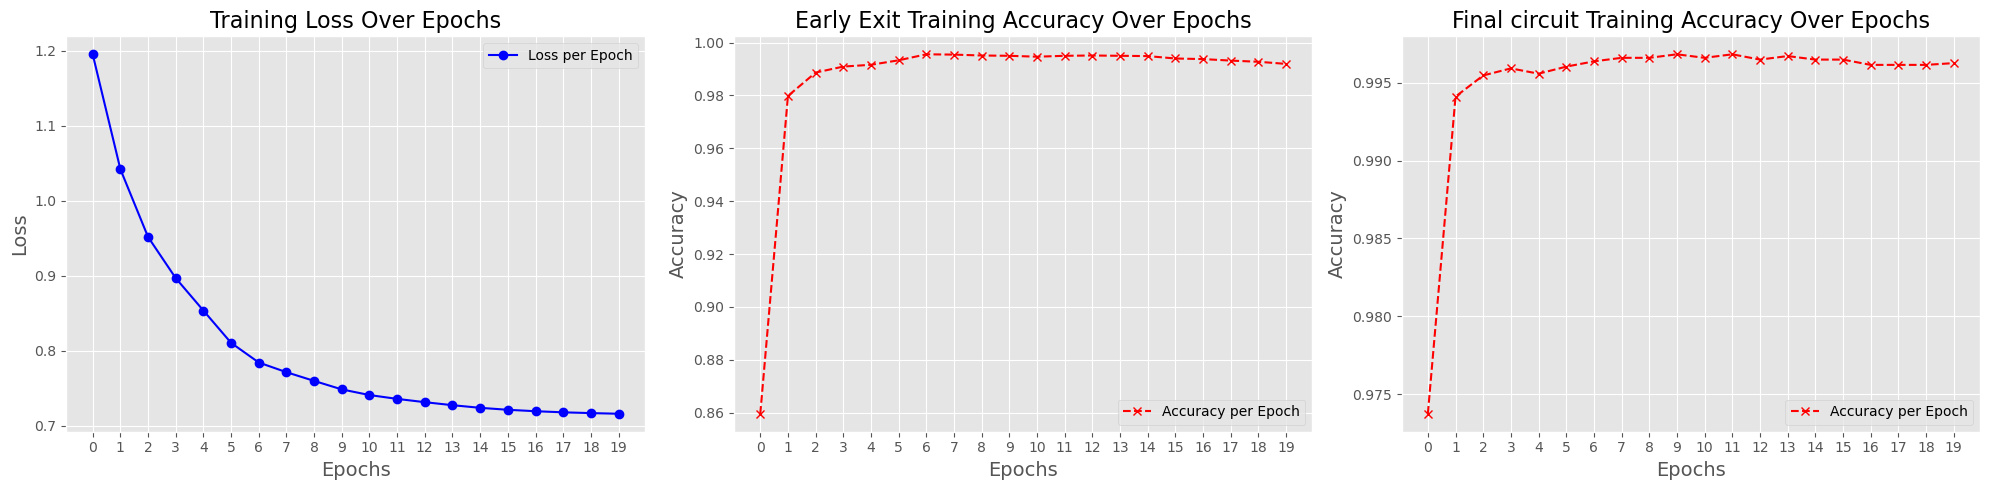

In [10]:
mcm_accuracy, fm_accuracy, loss_history = mcm_model.fit(dataloader=train_dataloader, learning_rate=0.001, epochs=20, show_plot=True)

## Early Exit with full-evaluation
Let's first try to execute every time the whole circuit for each image as it was trained, post-selecting the exit varying the threshold.  

In [11]:
prediction_results = {"early": [], "final": []}
for img, target in tqdm(test_dataloader.dataset):
    #img normalization
    img = img / torch.linalg.norm(img).view(-1, 1)
    #probs extraction
    mcm_probs, final_probs = mcm_model.forward(state=img)
    #mcm prediction and confidence
    mcm_predictions = torch.argmax(mcm_probs, dim=1)
    mcm_correct = mcm_predictions == target
    early_confidence = mcm_probs[0,mcm_predictions]
    prediction_results["early"].append((mcm_correct, early_confidence))
    
    #fm prediction
    final_predictions = torch.argmax(final_probs, dim=1)
    final_correct = final_predictions == target
    prediction_results["final"].append((final_correct))

100%|██████████| 1900/1900 [00:39<00:00, 47.58it/s]


`results['early']` will contain a list of tensors containing: 
- a boolean containing a True if the prediction was correct; 
- the confidence measure associated to measure 0 if 0 was predicted, associated to 1 if 1 was predicted


`results['final']` is a list of booleans containing True if the prediction was correct and Falso if it was uncorrect. 

Let's try to post select the exit varying the threshold, taking early prediction when the probability associated to the early prediciton is above a threshold and the final prediction when the condition is not satisfied: 

In [12]:
def post_evaluation_threshold(early_results, final_results, threshold):
    results = [] #chosen prediction per image
    count_1 = 0 #counter for early classified images
    count_2 = 0 #counter for final classified images
    mcm_correct = 0 #counter for correctly early classified images 
    final_correct = 0 #counter for correctly final classified images
    
    for i, (early_bool, confidence) in enumerate(early_results):
        if confidence.item() > threshold:
            results.append(early_bool.item()) #use early prediction
            count_1 += 1
            if early_bool: 
                mcm_correct += 1
        else:
            results.append(final_results[i][0].item()) #use final prediction
            count_2 += 1
            if final_results[i][0].item():
                final_correct += 1
            
    return results, mcm_correct, count_1, final_correct, count_2

In [13]:
def explain_results(results: Dict, threshold: List[float]):
    summary_data = {
        'Threshold': [],
        'Total Accuracy': [],
        'Early Classified': [],
        'Early Accuracy': [],
        'Final Classified': [],
        'Final Accuracy': []}
    
    for t in threshold:
        prediction_result, mcm_correct, n_early, final_correct, n_final = post_evaluation_threshold(results['early'], results['final'], t)

        tot_accuracy = sum([1 for i in prediction_result if i == True]) / len(prediction_result)
        
        #avoid division by 0
        early_accuracy = mcm_correct / n_early if n_early > 0 else 0
        final_accuracy = final_correct / n_final if n_final > 0 else 0

        summary_data['Threshold'].append(t)
        summary_data['Total Accuracy'].append(tot_accuracy)
        summary_data['Early Classified'].append(n_early)
        summary_data['Early Accuracy'].append(early_accuracy)
        summary_data['Final Classified'].append(n_final)
        summary_data['Final Accuracy'].append(final_accuracy)
        # print(f" tot accuracy {tot_accuracy}, average mean, {(n_early*early_accuracy + n_final*final_accuracy)/(n_early + n_final)}")
    
    df = pd.DataFrame(summary_data)
    return df

In [14]:
#threshold definition
threshold = [round(x * 0.02 + 0.3, 2) for x in range(31)]

In [15]:
explain_results(prediction_results, threshold)

,Threshold,Total Accuracy,Early Classified,Early Accuracy,Final Classified,Final Accuracy
0,0.30,0.991579,1900,0.991579,0,0.000000
1,0.32,0.991579,1900,0.991579,0,0.000000
2,0.34,0.991579,1900,0.991579,0,0.000000
3,0.36,0.991579,1900,0.991579,0,0.000000
4,0.38,0.991579,1900,0.991579,0,0.000000
5,0.40,0.991579,1900,0.991579,0,0.000000
6,0.42,0.991579,1900,0.991579,0,0.000000
7,0.44,0.991579,1900,0.991579,0,0.000000
8,0.46,0.991579,1900,0.991579,0,0.000000
9,0.48,0.991579,1900,0.991579,0,0.000000


# Early Exits without fully execution

We need to define a routine such that: 
1. take an image
2. execute the circuit up to the early exit 
3. extract prediction and confidence 
4. two possible scenarios: 
    - confidence > threshold --> take the mid circuit prediction
    - confidence > threshold --> run the whole circuit and take the final prediction 
5. repeat step 1,2,3,4 over the whole vali/test dataset

In [16]:
def early_evaluation_utils(params: Dict, state: torch.Tensor = None): 
    measurements = []
    if state is not None:
        # state vector initialization with input
        qml.QubitStateVector(state, wires=range(8))
    for i in range(4):
        for j in range(8):
            qml.RX(params[f'layer_{i}'][j, 0], wires=j)
            qml.RY(params[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(params[f'layer_{i}'][j, 2], wires=j)
        for j in range(8):
            qml.CNOT(wires=[j, (j + 1) % 8])
    measurements.append(qml.measure(wires=0)) #measure first qubit
    return measurements

def fully_evaluation_utils(params: Dict, state: torch.Tensor = None):
    mcasurements = []
    if state is not None:
        # state vector initialization with input
        qml.QubitStateVector(state, wires=range(8))
    for i in range(4):
        for j in range(8):
            qml.RX(params[f'layer_{i}'][j, 0], wires=j)
            qml.RY(params[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(params[f'layer_{i}'][j, 2], wires=j)
        for j in range(8):
            qml.CNOT(wires=[j, (j + 1) % 8])

    mcasurements.append(qml.measure(wires=0)) #measure first qubit

    for i in range(4, 8):
        for j in range(8):
            qml.RX(params[f'layer_{i}'][j, 0], wires=j)
            qml.RY(params[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(params[f'layer_{i}'][j, 2], wires=j)
        for j in range(8):
            qml.CNOT(wires=[j, (j + 1) % 8])

    mcasurements.append(qml.measure(wires=1)) #measure second qubit

    return mcasurements

In [17]:
#device definition
dev = qml.device("default.qubit", wires=8)
@qml.qnode(dev)  
def early_evaluation_ansatz(params: Dict, state: torch.Tensor = None):
    early_measurement = early_evaluation_utils(params=params, state=state)
    return qml.probs(op=early_measurement)

#dev2 = qml.device("default.qubit", wires=8)
@qml.qnode(dev)
def fully_evaluation_ansatz(params: Dict, state: torch.Tensor = None):
    measurements = fully_evaluation_utils(params=params, state=state)
    mid_measurement,final_measurement = measurements 
    return qml.probs(op=mid_measurement), qml.probs(op=final_measurement)

We can extract the trained parameters and plot the circuits that will be used for the evaluation: 

In [18]:
binary_parameters = mcm_model.params

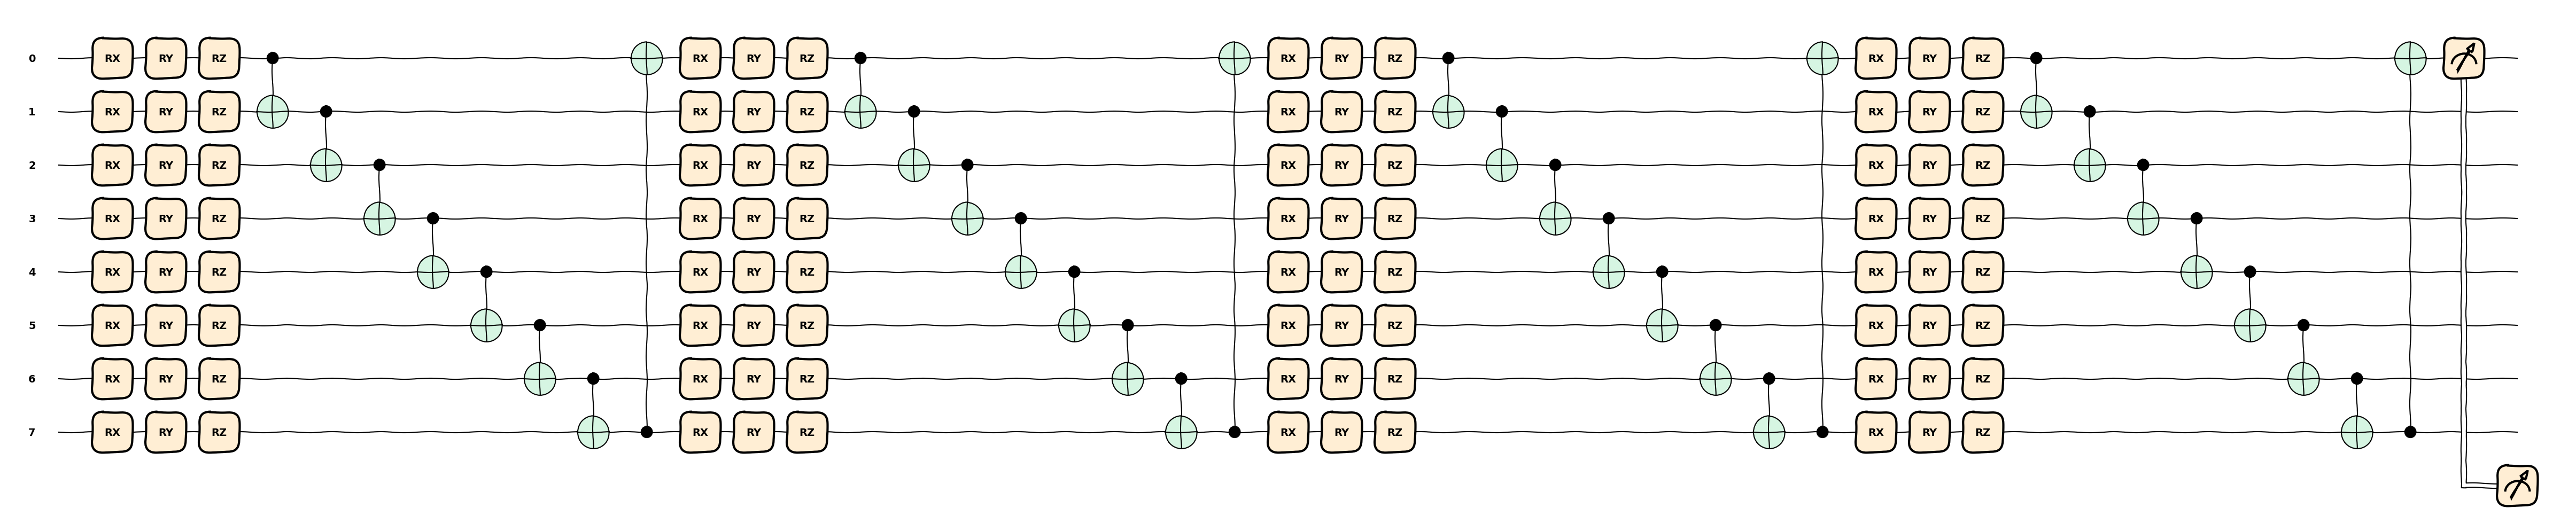

In [19]:
early_evaluate_model, ax1 = qml.draw_mpl(early_evaluation_ansatz)(binary_parameters)

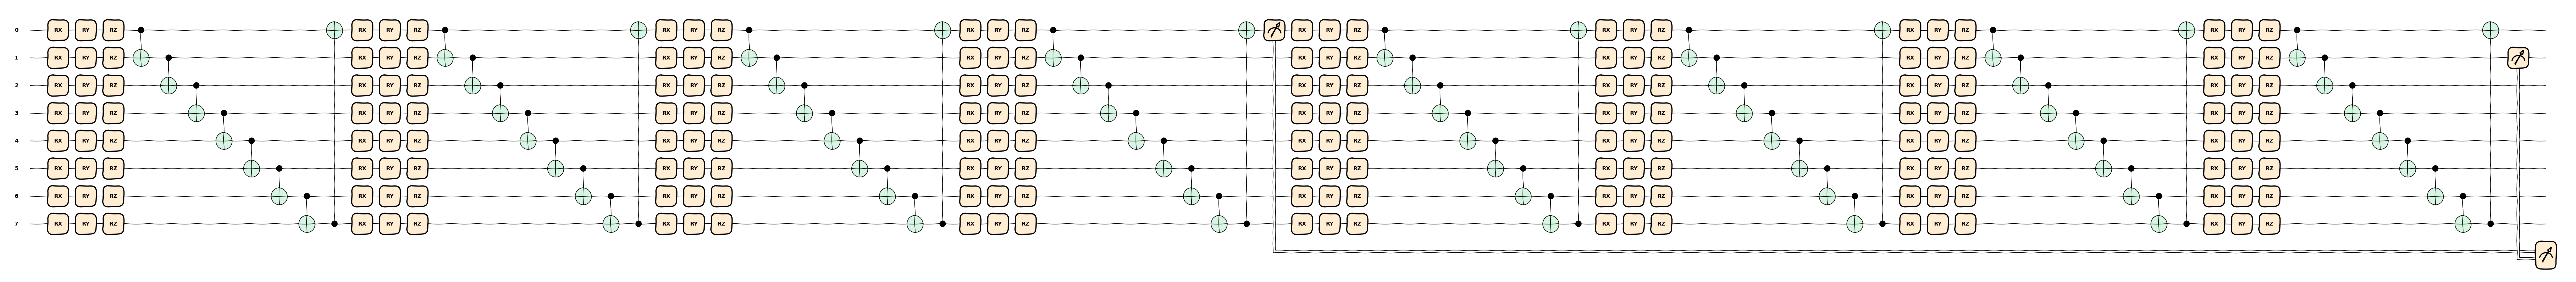

In [20]:
final_evaluate_model, ax2 = qml.draw_mpl(fully_evaluation_ansatz)(binary_parameters)

## Evaluation routine definition Analytic Mode
Let's define the routine that will be used for the evaluation.

In [21]:
def evaluation_routine(dataloader: DataLoader, parameters: Dict, threshold: float):
    
    evaluation_results = []
    count_1 = 0 #counter for early classified images
    count_2 = 0 #counter for final classified images
    early_correct = 0 #counter for correctly early classified images 
    final_correct = 0 #counter for correctly final classified images
    for img, target in dataloader.dataset:
        #img normalization
        img = img / torch.linalg.norm(img).view(-1, 1)
        
        #mid circuit evaluation
        early_probs = early_evaluation_ansatz(params=parameters, state=img)
        early_prediction = torch.argmax(early_probs, dim=1)
        confidence = early_probs[0, early_prediction].item()
        if confidence >= threshold:
            early_guess = early_prediction == target
            evaluation_results.append(early_guess.item())
            count_1 += 1
            if early_guess: 
                early_correct += 1
            
        else: 
            final_probs = fully_evaluation_ansatz(params=parameters, state=img)
            early_full, final_full = final_probs
            final_predictions = torch.argmax(final_full, dim=1)
            final_guess = final_predictions == target
            evaluation_results.append(final_guess.item())
            count_2 += 1
            if final_guess: 
                final_correct += 1
    total_accuracy = sum([1 for i in evaluation_results if i == True])/len(evaluation_results)
    early_accuracy = early_correct/count_1 if count_1 > 0 else 0
    final_accuracy = final_correct/count_2 if count_2 > 0 else 0
    
    return total_accuracy, early_accuracy, count_1, final_accuracy, count_2

In [22]:
def explain_evaluation(dataloader: DataLoader, parameters: Dict, threshold: List[float]):
    summary_data = {
    'Threshold': [],
    'Total Accuracy': [],
    'Early Classified': [],
    'Early Accuracy': [],
    'Final Classified': [],
    'Final Accuracy': []}
    
    for t in tqdm(threshold):
        tot_acc, early_acc, early_count, final_acc, final_count = evaluation_routine(dataloader, parameters, t)
        summary_data['Threshold'].append(t)
        summary_data['Total Accuracy'].append(tot_acc)
        summary_data['Early Classified'].append(early_count)
        summary_data['Early Accuracy'].append(early_acc)
        summary_data['Final Classified'].append(final_count)
        summary_data['Final Accuracy'].append(final_acc)
        
    df = pd.DataFrame(summary_data)
    return df

In [23]:
threshold = [round(x * 0.02 + 0.3, 2) for x in range(31)]
explain_evaluation(test_dataloader, binary_parameters, threshold)

100%|██████████| 31/31 [18:07<00:00, 35.08s/it]


,Threshold,Total Accuracy,Early Classified,Early Accuracy,Final Classified,Final Accuracy
0,0.30,0.991579,1900,0.991579,0,0.000000
1,0.32,0.991579,1900,0.991579,0,0.000000
2,0.34,0.991579,1900,0.991579,0,0.000000
3,0.36,0.991579,1900,0.991579,0,0.000000
4,0.38,0.991579,1900,0.991579,0,0.000000
5,0.40,0.991579,1900,0.991579,0,0.000000
6,0.42,0.991579,1900,0.991579,0,0.000000
7,0.44,0.991579,1900,0.991579,0,0.000000
8,0.46,0.991579,1900,0.991579,0,0.000000
9,0.48,0.991579,1900,0.991579,0,0.000000
